# Proyek Klasifikasi Gambar: Garbage Classification
[https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2]

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os, shutil
from shutil import copyfile
import zipfile
import random
from random import sample
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm as tq
from collections import Counter

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dimazandhika","key":"c1d069d379a6c3bf0a09a3496379a839"}'}

In [3]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sumn2u/garbage-classification-v2
!unzip garbage-classification-v2.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage-dataset/paper/paper_847.jpg  
  inflating: garbage-dataset/paper/paper_848.jpg  
  inflating: garbage-dataset/paper/paper_849.jpg  
  inflating: garbage-dataset/paper/paper_851.jpg  
  inflating: garbage-dataset/paper/paper_852.jpg  
  inflating: garbage-dataset/paper/paper_853.jpg  
  inflating: garbage-dataset/paper/paper_855.jpg  
  inflating: garbage-dataset/paper/paper_856.jpg  
  inflating: garbage-dataset/paper/paper_857.jpg  
  inflating: garbage-dataset/paper/paper_859.jpg  
  inflating: garbage-dataset/paper/paper_861.jpg  
  inflating: garbage-dataset/paper/paper_863.jpg  
  inflating: garbage-dataset/paper/paper_865.jpg  
  inflating: garbage-dataset/paper/paper_868.jpg  
  inflating: garbage-dataset/paper/paper_870.jpg  
  inflating: garbage-dataset/paper/paper_871.jpg  
  inflating: garbage-dataset/paper/paper_873.jpg  
  inflating: garbage-dataset/paper/paper_874.jpg  
  inflating: garbage-dataset/pa

In [5]:
img_data = '/content/garbage-dataset'

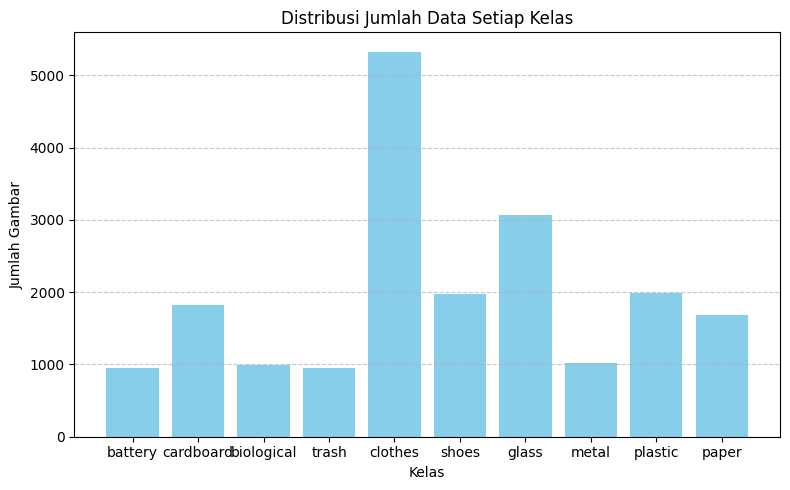

In [6]:
class_labels = [folder for folder in os.listdir(img_data) if os.path.isdir(os.path.join(img_data, folder))]

# Jumlah data setiap kelas
class_counts = {}
for label in class_labels:
    class_path = os.path.join(img_data, label)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[label] = len(image_files)

# Barplot
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Distribusi Jumlah Data Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

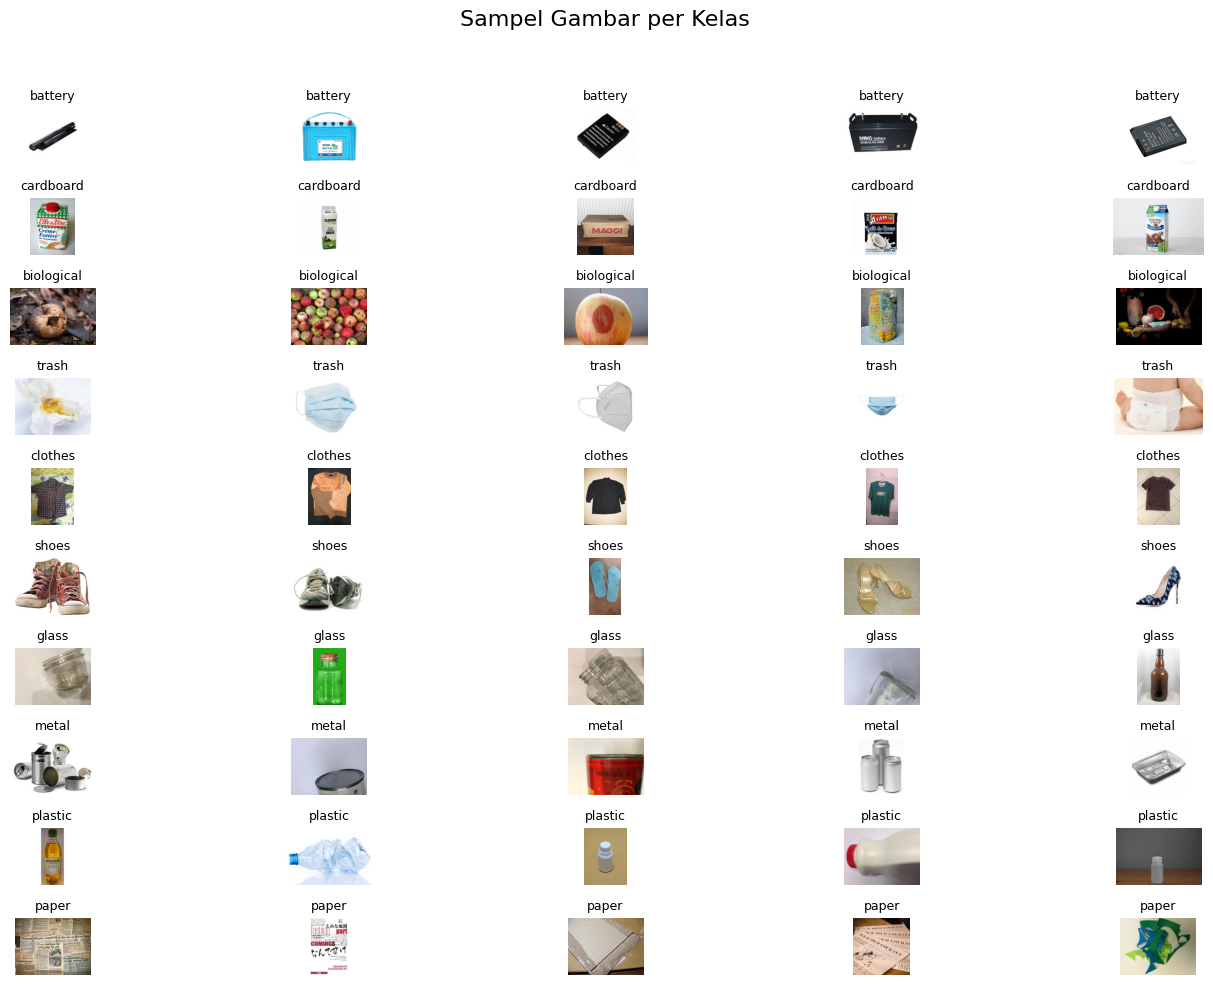

In [7]:
fig, axes = plt.subplots(len(class_labels), 5, figsize=(15, 10))
fig.suptitle('Sampel Gambar per Kelas', fontsize=16)

for row_idx, label in enumerate(class_labels):
    class_path = os.path.join(img_data, label)
    all_images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_images = all_images[:5]

    for col_idx, filename in enumerate(sample_images):
        img_path = os.path.join(class_path, filename)
        img = Image.open(img_path)

        axes[row_idx, col_idx].imshow(img)
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_title(label, fontsize=9)
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(label, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [8]:
total_images = 0
image_shapes = []

for label in class_labels:
    class_path = os.path.join(img_data, label)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    total_images += len(image_files)

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                image_shapes.append(img.size)  # (width, height)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

print(f"Total jumlah gambar: {total_images}")

# Cek keseragaman resolusi
unique_shapes = set(image_shapes)
print(f"Jumlah resolusi unik: {len(unique_shapes)}")

Total jumlah gambar: 19762
Jumlah resolusi unik: 2731


Berdasarkan output di atas, diperoleh dataset memiliki resolusi yang tidak seragam

### Data Preprocessing

#### Split Dataset

In [9]:
# Folder source
source_dr = '/content/garbage-dataset'
# Folder hasil split
output_dr = '/content/dataset_split'

for class_name in class_labels:
    class_dir = os.path.join(source_dr, class_name)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    # Split train, val, test
    train_imgs, test_imgs = train_test_split(images, train_size=0.8, random_state=42)

    # Copy file
    def copy_files(img_list, split_name):
        split_class_dir = os.path.join(output_dr, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img_name in img_list:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_class_dir, img_name)
            shutil.copy2(src, dst)

    copy_files(train_imgs, 'train')
    copy_files(test_imgs, 'test')

    print(f"{class_name}: {len(train_imgs)} train | {len(test_imgs)} test")

battery: 755 train | 189 test
cardboard: 1460 train | 365 test
biological: 797 train | 200 test
trash: 757 train | 190 test
clothes: 4261 train | 1066 test
shoes: 1581 train | 396 test
glass: 2448 train | 613 test
metal: 816 train | 204 test
plastic: 1587 train | 397 test
paper: 1344 train | 336 test


In [10]:
df_tr = '/content/dataset_split/train'
df_te = '/content/dataset_split/test'

In [11]:
img_size = 224, 224
batch_size = 32

# Augmentasi
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=40,  # Rotasi
    width_shift_range=0.2,  # Geser horizontal
    height_shift_range=0.2,  # Geser vertikal
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in atau zoom out
    horizontal_flip=True,  # Membalik horizontal
    fill_mode='nearest',
    validation_split=0.2
)

# Train
train_generator = train_datagen.flow_from_directory(
    df_tr,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation
validation_generator = train_datagen.flow_from_directory(
    df_tr,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    df_te,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12648 images belonging to 10 classes.
Found 3158 images belonging to 10 classes.
Found 3956 images belonging to 10 classes.


## Modelling

In [21]:
# Callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

In [23]:
# Menggunakan DenseNet201 sebagai feature extractor
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 32)       │       552,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,880,490 (72.02 MB)

 Trainable params: 558,506 (2.13 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [24]:
# Melatih model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6478 - loss: 1.1124
Epoch 1: val_accuracy improved from -inf to 0.85054, saving model to best_model.keras
396/396 ━━━━━━━━━━━━━━━━━━━━ 313s 690ms/step - accuracy: 0.6481 - loss: 1.1115 - val_accuracy: 0.8505 - val_loss: 0.4653 - learning_rate: 1.0000e-04
Epoch 2/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8670 - loss: 0.3940
Epoch 2: val_accuracy improved from 0.85054 to 0.88189, saving model to best_model.keras
396/396 ━━━━━━━━━━━━━━━━━━━━ 220s 556ms/step - accuracy: 0.8670 - loss: 0.3939 - val_accuracy: 0.8819 - val_loss: 0.3754 - learning_rate: 1.0000e-04
Epoch 3/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9000 - loss: 0.3198
Epoch 3: val_accuracy did not improve from 0.88189
396/396 ━━━━━━━━━━━━━━━━━━━━ 217s 548ms/step - accuracy: 0.9000 - loss: 0.3198 - val_accuracy: 0.8803 - val_loss: 0.3594 - learning_rate: 1.0000e-04
Epoch 4/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accurac

## Evaluasi dan Visualisasi

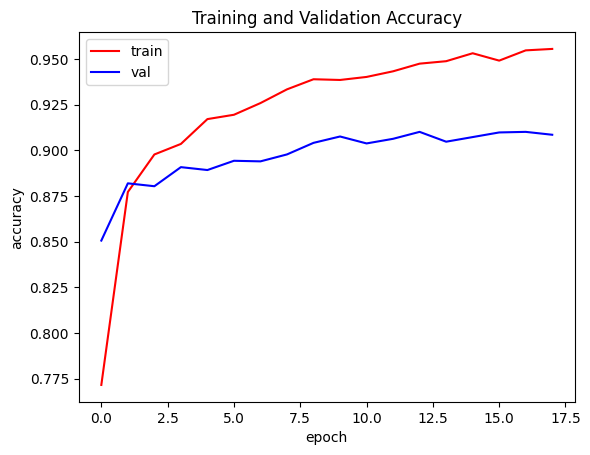

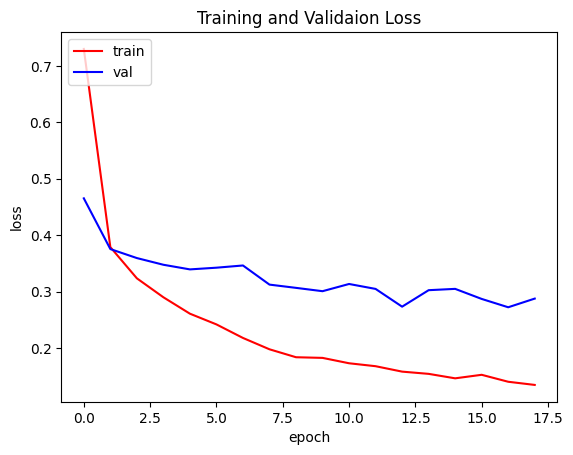

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()


Classification Report:

              precision    recall  f1-score   support

     Class 0     0.9526    0.9577    0.9551       189
     Class 1     0.9510    0.9700    0.9604       200
     Class 2     0.9229    0.8849    0.9035       365
     Class 3     0.9805    0.9897    0.9851      1066
     Class 4     0.9334    0.9380    0.9357       613
     Class 5     0.7888    0.8971    0.8394       204
     Class 6     0.8859    0.8780    0.8819       336
     Class 7     0.9299    0.8690    0.8984       397
     Class 8     0.9650    0.9747    0.9698       396
     Class 9     0.8315    0.8053    0.8182       190

    accuracy                         0.9328      3956
   macro avg     0.9142    0.9164    0.9148      3956
weighted avg     0.9334    0.9328    0.9327      3956


Accuracy: 0.9328


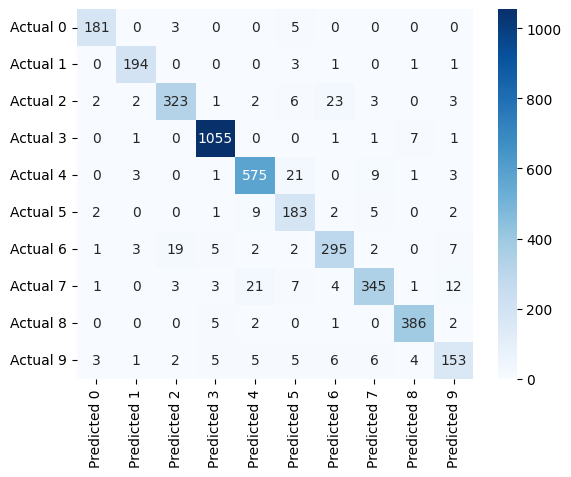

In [29]:
test_generator.reset()

# Predict
preds = model.predict(test_generator, verbose=0)

# Menggunakan argmax
preds_classes = np.argmax(preds, axis=1)

# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_classes, labels=range(10)),
    index=[f"Actual {i}" for i in range(10)],
    columns=[f"Predicted {i}" for i in range(10)]
)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds_classes,
    target_names=[f"Class {i}" for i in range(10)],
    digits=4
))

# Accuracy
accuracy = accuracy_score(test_generator.classes, preds_classes)
print(f"\nAccuracy: {accuracy:.4f}")

## Konversi Model

### Format SavedModel

In [31]:
path = 'saved_model/'
tf.saved_model.save(model, path)

### Format TF-Lite

In [32]:
# Menyimpan model dalam format SavedModel
export_dir = 'tflite/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

# class_labels -> sudah di define sebelumnya
# Menyimpan label
with open('label.txt', 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")

### Format TFJS

In [33]:
model.save("model.h5")

# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-27 08:36:41.469026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745743001.496640   29204 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

## Inference (Optional)

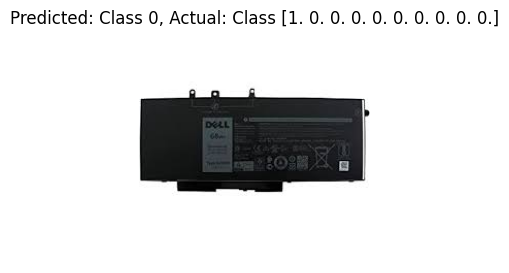

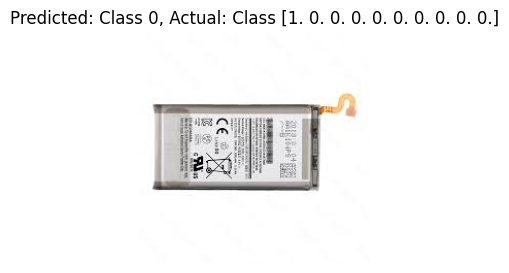

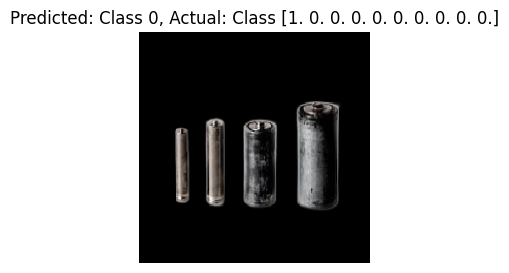

In [39]:
test_generator.reset()

# Mengambil 3 data dari test generator
inputs, labels = next(test_generator)

# Pilih 3 data secara acak
indices = random.sample(range(len(inputs)), 3)
random_inputs = inputs[indices]
random_labels = labels[indices]

# Ubah input data menjadi tensor
input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)

# Memuat model SavedModel
saved_model = tf.saved_model.load("/content/saved_model")

# Fungsi untuk melakukan prediksi
def infer(model, input_data):
    infer_func = model.signatures['serving_default']
    predictions = infer_func(input_data)
    return predictions
predictions = infer(saved_model, input_tensor)

# Hasil prediksi
preds = predictions['output_0']
preds_classes = np.argmax(preds, axis=1)

# Data asli
for i in range(3):
    plt.figure(figsize=(3, 3))
    plt.imshow(inputs[i])  # Gambar input
    plt.title(f"Predicted: Class {preds_classes[i]}, Actual: Class {labels[i]}")
    plt.axis('off')
    plt.show()